# Import Libraries

In [ ]:
import random

import torch
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

from sklearn.neighbors import LocalOutlierFactor

import jax.numpy as jnp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

colab_root = "/content/drive/MyDrive/my_google_colab/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get Text Data

In [ ]:
work_dir = f"{colab_root}NLP/text_summarization/"

In [ ]:
txt = f"{work_dir}data/text.txt"

txtFile = open(txt, 'r')
data = np.array(txtFile.read().split('\n%$#@\n'))
txtFile.close()

print(f"{len(data)} Wikipedia articles.")

428 Wikipedia articles.


In [ ]:
text = list()
labels = list()

for i in range(len(data)):

  try:
    t = data[i].split("\n*#@$#\n")

    label = t[1]

    text += [t[0]]
    labels += [label]

  except: continue

text = np.array(text)
labels = np.array(labels)

# LLM

In [ ]:
from transformers import AutoTokenizer, FlaxBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = FlaxBertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing FlaxBertForSequenceClassification: {('cls', 'predictions', 'transform', 'LayerNorm', 'scale'), ('cls', 'predictions', 'transform', 'dense', 'bias'), ('cls', 'predictions', 'bias'), ('cls', 'predictions', 'transform', 'LayerNorm', 'bias'), ('cls', 'predictions', 'transform', 'dense', 'kernel')}
- This IS expected if you are initializing FlaxBertForSequenceClassification from th

# Some Functions


In [ ]:
def text_to_hidden(text_list, model = None, tokenizer = None, batch_size = 128, return_np = False):

  if ((tokenizer is None) or (model is None)): return None
  inputs = tokenizer(list(text_list), return_tensors="jax", padding=True).input_ids

  hidden_states = None

  for b in range(0, len(text_list), batch_size):
    batch = inputs[b:b+batch_size]

    with torch.no_grad():
      batch_out = model(batch, output_hidden_states = True).hidden_states[-1]

    if (hidden_states is None):
      hidden_states = batch_out.copy()
    else:
      hidden_states = np.concatenate((hidden_states, batch_out), axis = 0)

  if (return_np): return np.array(hidden_states)
  else: return torch.tensor(hidden_states)

In [ ]:
def plot_low_dim_data(low_dim_data, labels = None):

  print(f"{len(labels)} data points.")
  df = pd.DataFrame(low_dim_data, columns=['dim1', 'dim2'])

  if (labels is not None):
      df['Labels'] = labels
      sb.scatterplot(data=df, x='dim1', y='dim2', hue='Labels')
      plt.legend(title='Labels')

  else:
      sb.scatterplot(data=df, x='dim1', y='dim2')

  plt.xlabel('dim1')
  plt.ylabel('dim2')

  plt.show()

In [ ]:
def get_rand_sample(x, y, sample_size = 100):
  if (sample_size is None): return x, y

  rand_index = lambda: int(random.random()*(len(x)-1))

  indices = set()

  while (len(indices) < sample_size): indices.add(rand_index())

  return x[list(indices)], y[list(indices)]

# Prep Data


In [ ]:
while (True):

  sample_size = input("Sample size (enter 0 for all): ")

  try:

    sample_size = int(sample_size)
    if (sample_size == 0): sample_size = None
    elif (sample_size < 0):
      print("Please enter a non-negative integer.")
      continue

    break

  except: print("Please enter a non-negative integer.\n")

Sample size (enter 0 for all): 0


In [ ]:
# if I only want to use a sample of the dataset
text, labels = get_rand_sample(x = text, y = labels, sample_size = sample_size)

# training & testing split
X_train, X_test, Y_train, Y_test = train_test_split(text, labels, test_size=0.2, random_state=18)

print(f"X_train: {X_train.shape}; Y_train: {Y_train.shape}")
print(f" X_test: {X_test.shape};  Y_test: {Y_test.shape}")

X_train: (341,); Y_train: (341,)
 X_test: (86,);  Y_test: (86,)


In [ ]:
def separate_paragraphs(X, Y):

  new_X = []
  new_Y = []
  for i in range(X.shape[0]):
    paragraphs = X[i].split("\n--\n--\n")
    new_X += paragraphs
    new_Y += [Y[i] for x in range(len(paragraphs))]

  return np.array(new_X), np.array(new_Y)

X_train, Y_train = separate_paragraphs(X_train, Y_train)
X_test, Y_test = separate_paragraphs(X_test, Y_test)

print(f"X_train: {X_train.shape}; Y_train: {Y_train.shape}")
print(f" X_test: {X_test.shape};  Y_test: {Y_test.shape}")

X_train: (9040,); Y_train: (9040,)
 X_test: (2403,);  Y_test: (2403,)


In [ ]:
X_train = text_to_hidden(text_list = X_train,
                         model = model,
                         tokenizer = tokenizer,
                         batch_size = 128,
                         return_np = True)

print(f"X_train hidden shape: {X_train.shape}")

X_test = text_to_hidden(text_list = X_test,
                        model = model,
                        tokenizer = tokenizer,
                        batch_size = 128,
                        return_np = True)

print(f"X_test hidden shape:  {X_test.shape}")


X_train = X_train.sum(axis = 1)
print(f"\nX_train input shape:  {X_train.shape}")

X_test = X_test.sum(axis = 1)
print(f"X_test input shape:   {X_test.shape}")

X_train hidden shape: (9040, 509, 768)
X_test hidden shape:  (2403, 474, 768)

X_train input shape:  (9040, 768)
X_test input shape:   (2403, 768)


# Removing Outliers in Training Set

In [ ]:
remove_outliers = input("Remove outliers in training set: ")
remove_outliers = (remove_outliers == 'yes' or remove_outliers == 'Yes' or remove_outliers == 'Y' or remove_outliers == 'y')

Remove outliers in training set: yes


In [ ]:
# remove outliers in training set using Local Outlier Factor (LOF) metric

if (remove_outliers):

  print("Original shapes:\n")
  print(f"X_train: {X_train.shape}; Y_train: {Y_train.shape}")
  print(f" X_test: {X_test.shape};  Y_test: {Y_test.shape}")

  index_col = np.arange(X_train.shape[0])[:, np.newaxis]
  X_train = np.concatenate((X_train, index_col), axis=1)

  outlier_indices = list()

  for y in list(set(Y_train)):

    LOF = LocalOutlierFactor(n_neighbors=24)
    class_X = X_train[np.where(Y_train == y)[0]]
    LOF_outliers = LOF.fit_predict(class_X)
    LOF_scores = LOF.negative_outlier_factor_

    class_outlier_indices = np.where(LOF_scores < -1.25)[0]

    outlier_indices += list(np.array(class_X[class_outlier_indices][:, -1], dtype = np.int64))


  X_train = np.delete(X_train, outlier_indices, axis = 0)
  Y_train = np.delete(Y_train, outlier_indices, axis = 0)

  X_train = np.delete(X_train, -1, axis = 1)

  print("\n\nAfter removing outliers:\n")
  print(f"X_train: {X_train.shape}; Y_train: {Y_train.shape}")
  print(f" X_test: {X_test.shape};  Y_test: {Y_test.shape}")

Original shapes:

X_train: (9040, 768); Y_train: (9040,)
 X_test: (2403, 768);  Y_test: (2403,)


After removing outliers:

X_train: (8751, 768); Y_train: (8751,)
 X_test: (2403, 768);  Y_test: (2403,)


# t-SNE Visualization

8751 data points.


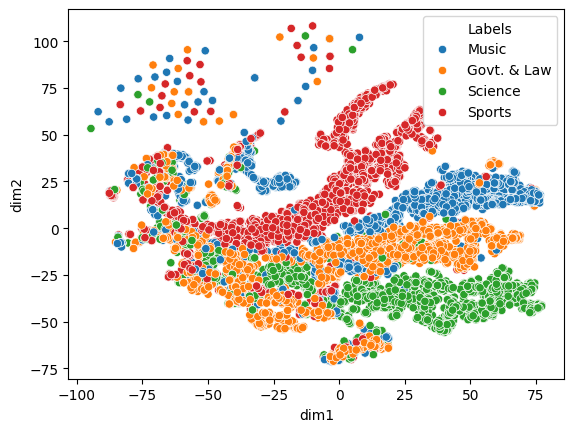

In [ ]:
plot_tsne = True
just_train_set = True

if (plot_tsne):

  if (just_train_set):
    hidden_states = X_train
    labels = Y_train
  else:
    hidden_states = np.concatenate((X_train, X_test), axis = 0)
    labels = np.concatenate((Y_train, Y_test), axis = 0)

  tsne = TSNE(n_components=2, random_state=18)
  tsne_data = tsne.fit_transform(torch.flatten(torch.tensor(hidden_states), start_dim = 1))

  plot_low_dim_data(low_dim_data = tsne_data,
                    labels = labels)

# Save Data


In [ ]:
save_data = input("Save data: ")
save_data = (save_data == 'yes' or save_data == 'Yes' or save_data == 'Y' or save_data == 'y')

Save data: yes


In [ ]:
if (save_data):

  np.save(f"{work_dir}data/X_train.npy", X_train)
  np.save(f"{work_dir}data/Y_train.npy", Y_train)

  np.save(f"{work_dir}data/X_test.npy", X_test)
  np.save(f"{work_dir}data/Y_test.npy", Y_test)

  print(f"Successfully saved to \n{work_dir}data/")

Successfully saved to 
/content/drive/MyDrive/my_google_colab/NLP/text_summarization/data/
